In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dataset/dataset_harga_beras.xlsx
/kaggle/input/dataset/dataset_hama.xlsx
/kaggle/input/dataset/dataset_rainfall_all.xlsx


In [3]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, r2_score, mean_absolute_percentage_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import time

# --- Load and prepare data ---
def create_sequences(data, lookback):
    X, y = [], []
    for i in range(len(data) - lookback):
        X.append(data[i:i+lookback])
        y.append(data[i+lookback])
    return np.array(X), np.array(y)

# --- Read dataset ---
df = pd.read_excel("/kaggle/input/dataset/dataset_rainfall_all.xlsx", sheet_name="Sheet2")
df['tanggal'] = pd.to_datetime(df['tanggal'], dayfirst=True)
df = df.sort_values('tanggal')
df = df.dropna(subset=['rr'])  # univariate: hanya kolom 'rr'

# --- Gunakan data 3 tahun terakhir untuk baseline ---
df_3yr = df[df['tanggal'] >= pd.to_datetime('2021-01-01')].copy()
data = df_3yr['rr'].values.reshape(-1, 1)

# --- Normalisasi dan split ---
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)
lookback = 30

X, y = create_sequences(data_scaled, lookback)
split = int(len(X) * 0.8)
X_train, y_train = X[:split], y[:split]
X_test, y_test = X[split:], y[split:]

# --- Build model (baseline) ---
model = Sequential([
    LSTM(32, input_shape=(lookback, 1)),
    Dense(1)
])
model.compile(loss='mse', optimizer='adam')

# --- Train model ---
start_time = time.time()
model.fit(X_train, y_train, epochs=50, batch_size=16, validation_split=0.2, verbose=0)
training_time = time.time() - start_time

# --- Evaluate model ---
y_pred = model.predict(X_test)
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

mae = mean_absolute_error(y_test_inv, y_pred_inv)
r2 = r2_score(y_test_inv, y_pred_inv)
smape = 100 * np.mean(2 * np.abs(y_pred_inv - y_test_inv) / (np.abs(y_pred_inv) + np.abs(y_test_inv)))

# --- Print results ---
print(f"Baseline Univariate (3 Tahun)")
print(f"MAE : {mae:.3f} mm")
print(f"R²  : {r2:.3f}")
print(f"SMAPE : {smape:.2f}%")
print(f"Training Time : {training_time:.2f} seconds")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Baseline Univariate (3 Tahun)
MAE : 16.507 mm
R²  : -0.028
SMAPE : 123.61%
Training Time : 11.34 seconds


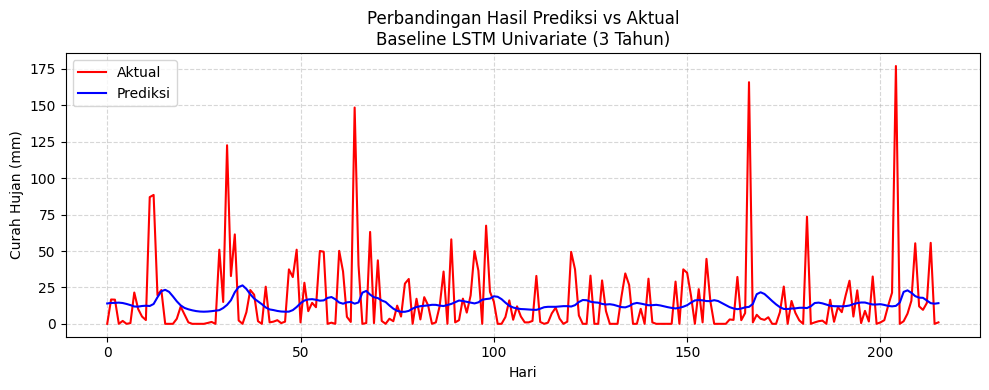

In [7]:
import matplotlib.pyplot as plt

# --- Plot prediksi vs aktual (dalam skala asli) ---
plt.figure(figsize=(10, 4))
plt.plot(y_test_inv, label='Aktual', color='red')
plt.plot(y_pred_inv, label='Prediksi', color='blue')
plt.title('Perbandingan Hasil Prediksi vs Aktual\nBaseline LSTM Univariate (3 Tahun)')
plt.xlabel('Hari')
plt.ylabel('Curah Hujan (mm)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

**MULTIVARITE BASELINE**

In [8]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import time
import matplotlib.pyplot as plt

# --- Load dataset ---
df = pd.read_excel("/kaggle/input/dataset/dataset_rainfall_all.xlsx", sheet_name="Sheet2")
df['tanggal'] = pd.to_datetime(df['tanggal'], dayfirst=True)
df = df.sort_values('tanggal')

# Pilih fitur multivariat yang tersedia
features = ['rr', 'tavg', 'rh_avg', 'ff_avg']  # sesuaikan dengan datasetmu
df = df.dropna(subset=features)

# Gunakan data 3 tahun terakhir untuk baseline
df_3yr = df[df['tanggal'] >= pd.to_datetime('2021-01-01')].copy()

# Normalisasi
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(df_3yr[features])
lookback = 30

# --- Buat sequence data ---
def create_sequences_multivariate(data, lookback):
    X, y = [], []
    for i in range(len(data) - lookback):
        X.append(data[i:i+lookback])
        y.append(data[i+lookback][0])  # target: rr
    return np.array(X), np.array(y)

X, y = create_sequences_multivariate(data_scaled, lookback)
split = int(len(X) * 0.8)
X_train, y_train = X[:split], y[:split]
X_test, y_test = X[split:], y[split:]

# --- Build baseline model ---
model = Sequential([
    LSTM(32, input_shape=(lookback, len(features))),
    Dense(1)
])
model.compile(loss='mse', optimizer='adam')

# --- Train model ---
start = time.time()
model.fit(X_train, y_train, epochs=50, batch_size=16, validation_split=0.2, verbose=0)
training_time = time.time() - start

# --- Evaluate ---
y_pred = model.predict(X_test)
rr_index = features.index('rr')
scaler_rr = MinMaxScaler()
scaler_rr.min_, scaler_rr.scale_ = scaler.min_[rr_index], scaler.scale_[rr_index]

y_pred_inv = y_pred * scaler.scale_[rr_index] + scaler.min_[rr_index]
y_test_inv = y_test.reshape(-1, 1) * scaler.scale_[rr_index] + scaler.min_[rr_index]

mae = mean_absolute_error(y_test_inv, y_pred_inv)
r2 = r2_score(y_test_inv, y_pred_inv)
smape = 100 * np.mean(2 * np.abs(y_pred_inv - y_test_inv) / (np.abs(y_pred_inv) + np.abs(y_test_inv)))

# --- Print result ---
print("Baseline Multivariate (3 Tahun)")
print(f"MAE : {mae:.3f} mm")
print(f"R²  : {r2:.3f}")
print(f"SMAPE : {smape:.2f}%")
print(f"Training Time : {training_time:.2f} seconds")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Baseline Multivariate (3 Tahun)
MAE : 0.000 mm
R²  : 0.128
SMAPE : 124.72%
Training Time : 11.81 seconds


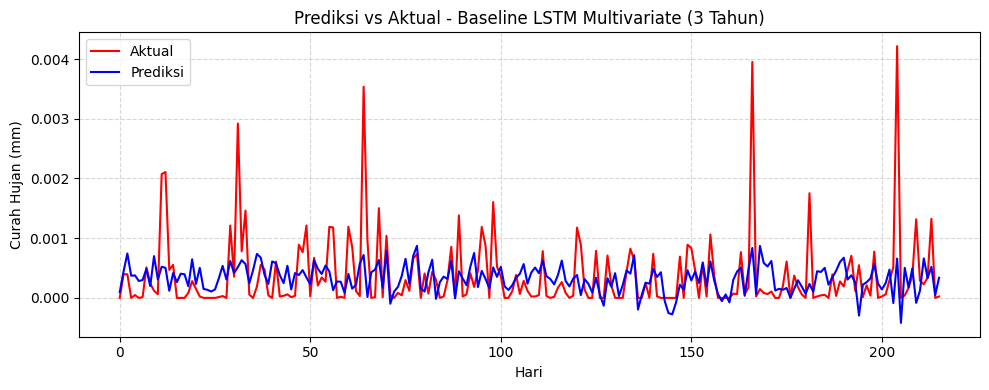

In [10]:
# ---  plot actual vs predicted ---
plt.figure(figsize=(10, 4))
plt.plot(y_test_inv, label='Aktual', color='red')
plt.plot(y_pred_inv, label='Prediksi', color='blue')
plt.title('Prediksi vs Aktual - Baseline LSTM Multivariate (3 Tahun)')
plt.xlabel('Hari')
plt.ylabel('Curah Hujan (mm)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

**MULTIVARIATE TUNING**

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from time import time
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.models import Sequential, save_model
from tensorflow.keras.models import load_model
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tqdm.notebook import tqdm
from time import time
import joblib
import random
import tensorflow as tf

# Load & preprocess data
df = pd.read_excel("/kaggle/input/dataset/dataset_rainfall_all.xlsx", sheet_name="Sheet1")
df['tanggal'] = pd.to_datetime(df['tanggal'], dayfirst=True)
df = df.sort_values('tanggal')
features = ['tavg', 'rh_avg', 'ss']
target = 'rr'
df[features + [target]] = df[features + [target]].interpolate(method='linear').bfill().ffill()

# Normalize
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_x.fit_transform(df[features])
y_scaled = scaler_y.fit_transform(df[[target]])

# Create dataset
def create_dataset(X, y, lookback=30):
    Xs, ys = [], []
    for i in range(lookback, len(X)):
        Xs.append(X[i-lookback:i])
        ys.append(y[i])
    return np.array(Xs), np.array(ys)

X_seq, y_seq = create_dataset(X_scaled, y_scaled, lookback=30)
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, shuffle=False, random_state = 42)

# Build and train LSTM regression model
model_reg = Sequential([
    LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    Dense(1)
])
model_reg.compile(optimizer='adam', loss=MeanSquaredError())

start_time = time()
model_reg.fit(X_train, y_train, epochs=50, batch_size=12, validation_split=0.1, verbose=0)
training_time = time() - start_time

# Evaluate
y_pred_scaled = model_reg.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_true = scaler_y.inverse_transform(y_test)

mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)
smape = 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true) + 1e-8))

print(f"MAE: {mae:.2f} mm")
print(f"R² Score: {r2:.4f}")
print(f"SMAPE: {smape:.2f}%")
print(f"Training Time: {training_time:.2f} seconds")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
MAE: 12.66 mm
R² Score: 0.1447
SMAPE: 126.59%
Training Time: 44.78 seconds


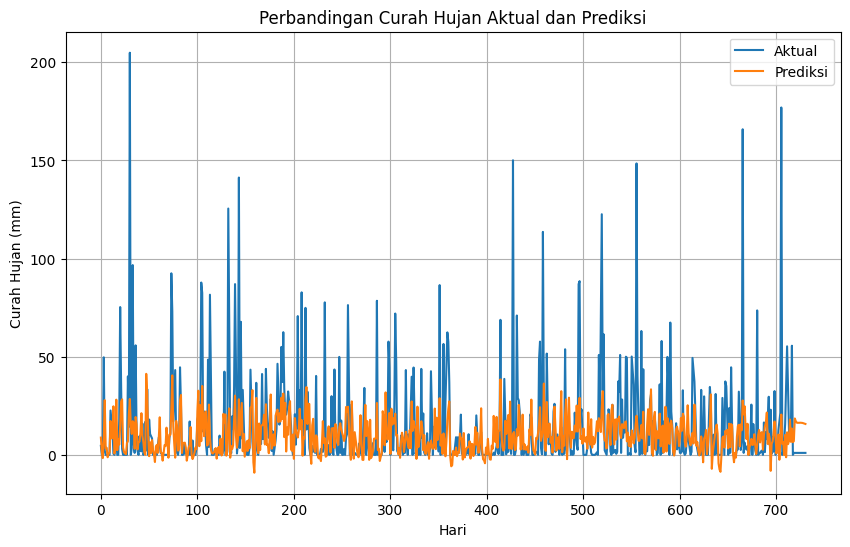

In [15]:
import matplotlib.pyplot as plt

# Plot 100 hari pertama hasil prediksi vs aktual
plt.figure(figsize=(10,6))
# plt.plot(y_true[:100], label='Aktual')
# plt.plot(y_pred[:100], label='Prediksi')
plt.plot(y_true, label='Aktual')
plt.plot(y_pred, label='Prediksi')
plt.title('Perbandingan Curah Hujan Aktual dan Prediksi')
plt.xlabel('Hari')
plt.ylabel('Curah Hujan (mm)')
plt.legend()
plt.grid(True)
plt.show()